In [1]:
#pip install autofeat

In [1]:
import os
import sys
import warnings
import sklearn
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston, load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from autofeat import AutoFeatRegressor

%matplotlib inline
%load_ext autoreload
%autoreload 2

# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
np.seterr(divide = 'ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
#regr adatbeolvasó fv.
def load_regression_dataset(name):
    units = {}
    if name == "boston":
        X, y = load_boston(True)
    elif name == "diabetes":
        X, y = load_diabetes(True)
    else:
        raise RuntimeError("Unknown dataset %r" % name)
    return np.array(X, dtype=float), np.array(y, dtype=float), units

In [3]:
#módosított modell tesztelő fv.
def test_model(X, y, model, param_grid):
    # load data
    #X, y, _ = load_regression_dataset(dataset)
    # split in training and test parts
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    
    if model.__class__.__name__ == "SVR":
        sscaler = StandardScaler()
        X_train = sscaler.fit_transform(X_train)
        X_test = sscaler.transform(X_test)
        
    # train model on train split incl cross-validation for parameter selection
    gsmodel = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
    gsmodel.fit(X_train, y_train)
    print("best params:", gsmodel.best_params_)
    print("best score:", gsmodel.best_score_)
    print("MSE on training data:", mean_squared_error(y_train, gsmodel.predict(X_train)))
    print("MSE on test data:", mean_squared_error(y_test, gsmodel.predict(X_test)))
    print("R^2 on training data:", r2_score(y_train, gsmodel.predict(X_train)))
    print("R^2 on test data:", r2_score(y_test, gsmodel.predict(X_test)))
    return gsmodel.best_estimator_

In [4]:
#módosított autofeat modell tesztelő fv.
def test_autofeat(X, y, units, feateng_steps=2):
    # load data
    #X, y, units = load_regression_dataset(dataset)
    # split in training and test parts
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    # run autofeat
    afreg = AutoFeatRegressor(verbose=1, feateng_steps=feateng_steps, units=units)
    # fit autofeat on less data, otherwise ridge reg model with xval will overfit on new features
    X_train_tr = afreg.fit_transform(X_train, y_train)
    X_test_tr = afreg.transform(X_test)
    print("autofeat new features:", len(afreg.new_feat_cols_))
    print("autofeat MSE on training data:", mean_squared_error(y_train, afreg.predict(X_train_tr)))
    print("autofeat MSE on test data:", mean_squared_error(y_test, afreg.predict(X_test_tr)))
    print("autofeat R^2 on training data:", r2_score(y_train, afreg.predict(X_train_tr)))
    print("autofeat R^2 on test data:", r2_score(y_test, afreg.predict(X_test_tr)))
    
    
    # train rreg on transformed train split incl cross-validation for parameter selection
    print("# Ridge Regression")
    rreg = Ridge()
    param_grid = {"alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1., 2.5, 5., 10., 25., 50., 100., 250., 500., 1000., 2500., 5000., 10000.]}
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gsmodel = GridSearchCV(rreg, param_grid, scoring='neg_mean_squared_error', cv=5)
        gsmodel.fit(X_train_tr, y_train)
    print("best params:", gsmodel.best_params_)
    print("best score:", gsmodel.best_score_)
    print("MSE on training data:", mean_squared_error(y_train, gsmodel.predict(X_train_tr)))
    print("MSE on test data:", mean_squared_error(y_test, gsmodel.predict(X_test_tr)))
    print("R^2 on training data:", r2_score(y_train, gsmodel.predict(X_train_tr)))
    print("R^2 on test data:", r2_score(y_test, gsmodel.predict(X_test_tr)))
    
    
    print("# Random Forest")
    rforest = RandomForestRegressor(n_estimators=100, random_state=13)
    param_grid = {"min_samples_leaf": [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2]}
    gsmodel = GridSearchCV(rforest, param_grid, scoring='neg_mean_squared_error', cv=5)
    gsmodel.fit(X_train_tr, y_train)
    print("best params:", gsmodel.best_params_)
    print("best score:", gsmodel.best_score_)
    print("MSE on training data:", mean_squared_error(y_train, gsmodel.predict(X_train_tr)))
    print("MSE on test data:", mean_squared_error(y_test, gsmodel.predict(X_test_tr)))
    print("R^2 on training data:", r2_score(y_train, gsmodel.predict(X_train_tr)))
    print("R^2 on test data:", r2_score(y_test, gsmodel.predict(X_test_tr)))
    
    
    print("# SVR")
    svr = SVR(gamma="scale")
    param_grid = {"C": [1., 10., 25., 50., 100., 250.]}
    sscaler = StandardScaler()
    X_train_tr = sscaler.fit_transform(X_train_tr)
    X_test_tr = sscaler.transform(X_test_tr)
    gsmodel = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=5)
    gsmodel.fit(X_train_tr, y_train)
    print("best params:", gsmodel.best_params_)
    print("best score:", gsmodel.best_score_)
    print("MSE on training data:", mean_squared_error(y_train, gsmodel.predict(X_train_tr)))
    print("MSE on test data:", mean_squared_error(y_test, gsmodel.predict(X_test_tr)))
    print("R^2 on training data:", r2_score(y_train, gsmodel.predict(X_train_tr)))
    print("R^2 on test data:", r2_score(y_test, gsmodel.predict(X_test_tr)))

In [5]:
#adatok beolvasása
X, y, units = load_regression_dataset("boston")
#új változók generálása autofeattel
afreg = AutoFeatRegressor(verbose=1, feateng_steps=2, units=units)
#és a legjobbak kiválasztása
X_af = afreg.fit_transform(X, y)
X_af.shape

[AutoFeat] The 2 step feature engineering process could generate up to 4186 features.
[AutoFeat] With 506 data points this new feature matrix would use about 0.01 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 60 transformed features from 13 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 2583 feature combinations from 2628 original feature tuples - done.
[feateng] Generated altogether 2645 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 1198 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 54 features after 5 feature selection runs
[featsel] 43 features after correlation filtering
[featsel] 21 features after noise filtering


(506, 33)

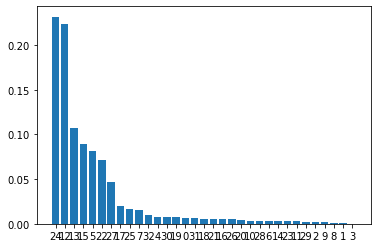

In [6]:
#randomforest illesztése a kibővített adathalmazra, hogy feature importance-t alkalmazzunk rajta
randforreg = RandomForestRegressor(random_state=13)
randforreg.fit(X_af, y)
#feature importance alkalmazása és ábrázolása
importances = randforreg.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X_af.shape[1]), importances[indices])
plt.xticks(range(X_af.shape[1]), indices)
plt.show()

In [9]:
select = []
columns=[]
#kiválasztom a legfontosabb featureket
for i,v in enumerate(importances):
    if v > 0.04:
        select.append(i)
for i in select:
    columns.append(X_af.columns[i])
#leszúkitem a fontos featurekkel az adathalmazt
XS_af = X_af[columns]
XS_af.shape

(506, 7)

## Adathalmaz tesztelése

In [10]:
dsname='boston'

In [13]:
#Ridge regresszió
print("####", dsname)
warnings.simplefilter("ignore")
rreg = Ridge()
params = {"alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1., 2.5, 5., 10., 25., 50., 100., 250., 500., 1000., 2500., 5000., 10000., 25000., 50000., 100000.]}
rreg = test_model(XS_af, y, rreg, params)

#### boston
best params: {'alpha': 0.01}
best score: -14.847513595970847
MSE on training data: 13.885690733375325
MSE on test data: 14.937686522928825
R^2 on training data: 0.8366491819488221
R^2 on test data: 0.8171872181735931


In [12]:
#SVR regresszió
print("####", dsname)
svr = SVR(gamma="scale")
params = {"C": [1., 10., 25., 50., 100., 250.]}
svr = test_model(XS_af, y, svr, params)

#### boston
best params: {'C': 100.0}
best score: -12.880297038563384
MSE on training data: 4.860078921462448
MSE on test data: 11.65474644037807
R^2 on training data: 0.9428261882784136
R^2 on test data: 0.8573650200132078


In [23]:
#random forest regresszió
print("####", dsname)
rforest = RandomForestRegressor(n_estimators=100, random_state=13)
params = {"min_samples_leaf": [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2]}
rforest = test_model(XS_af, y, rforest, params)

#### boston
best params: {'min_samples_leaf': 0.01}
best score: -21.444576255728133
MSE on training data: 12.847390898639864
MSE on test data: 16.35898987235349
R^2 on training data: 0.8488637077252588
R^2 on test data: 0.7997927964384283


In [24]:
#autofeat regresszió 1 steppel
print("####", dsname)
test_autofeat(XS_af, y, units, feateng_steps=1)

#### boston
[AutoFeat] The 1 step feature engineering process could generate up to 28 features.
[AutoFeat] With 404 data points this new feature matrix would use about 0.00 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 20 transformed features from 4 original features - done.
[feateng] Generated altogether 20 new features in 1 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 10 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 7 features after 5 feature selection runs
[featsel] 7 features after correlation filtering
[featsel] 6 features after noise filtering
[AutoFeat] Computing 2 new features.
[AutoFeat]     2/    2 new features ...done.
[AutoFeat] Final dataframe with 6 feature columns (2

In [25]:
#autofeat regresszió 2 steppel
print("####", dsname)
test_autofeat(XS_af, y, units, feateng_steps=2)

#### boston
[AutoFeat] The 2 step feature engineering process could generate up to 406 features.
[AutoFeat] With 404 data points this new feature matrix would use about 0.00 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 20 transformed features from 4 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 260 feature combinations from 276 original feature tuples - done.
[feateng] Generated altogether 286 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 87 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 16 features after 5 feature selection runs
[featsel] 12 features after correlation filtering
[featsel] 8 features after noise filter

In [26]:
#autofeat regresszió 3 steppel
print("####", dsname)
test_autofeat(XS_af, y, units, feateng_steps=3)

#### boston
[AutoFeat] The 3 step feature engineering process could generate up to 9478 features.
[AutoFeat] With 404 data points this new feature matrix would use about 0.02 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 20 transformed features from 4 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 1038 feature combinations from 276 original feature tuples - done.
[feateng] Step 3: transformation of new features
[feateng] Generated 4508 transformed features from 1038 original features - done.
[feateng] Generated altogether 5961 new features in 3 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 2563 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[feats